In [1]:
import h5py
from glob import glob
from scipy.optimize import curve_fit
from scipy.special import factorial
import pandas as pd
from tqdm import tqdm
import seaborn as sns

/home/dneise/anaconda3-5.1.0/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
ls out

iw_1_shift_0.h5   iw_2_shift_3.h5   iw_4_shift_-3.h5  iw_6_shift_2.h5
iw_1_shift_-1.h5  iw_3_shift_0.h5   iw_4_shift_3.h5   iw_6_shift_-3.h5
iw_1_shift_1.h5   iw_3_shift_-1.h5  iw_5_shift_0.h5   iw_6_shift_3.h5
iw_1_shift_-2.h5  iw_3_shift_1.h5   iw_5_shift_-1.h5  iw_7_shift_0.h5
iw_1_shift_2.h5   iw_3_shift_-2.h5  iw_5_shift_1.h5   iw_7_shift_-1.h5
iw_1_shift_-3.h5  iw_3_shift_2.h5   iw_5_shift_-2.h5  iw_7_shift_1.h5
iw_1_shift_3.h5   iw_3_shift_-3.h5  iw_5_shift_2.h5   iw_7_shift_-2.h5
iw_2_shift_0.h5   iw_3_shift_3.h5   iw_5_shift_-3.h5  iw_7_shift_2.h5
iw_2_shift_-1.h5  iw_4_shift_0.h5   iw_5_shift_3.h5   iw_7_shift_-3.h5
iw_2_shift_1.h5   iw_4_shift_-1.h5  iw_6_shift_0.h5   iw_7_shift_3.h5
iw_2_shift_-2.h5  iw_4_shift_1.h5   iw_6_shift_-1.h5
iw_2_shift_2.h5   iw_4_shift_-2.h5  iw_6_shift_1.h5
iw_2_shift_-3.h5  iw_4_shift_2.h5   iw_6_shift_-2.h5


In [3]:
paths = list(sorted(glob('out/*.h5')))
paths = [p for p in paths if len(p) < 35]

In [4]:
def parse_path(p):
    x = p.replace('out/iw_', '').replace('.h5', '')
    y = list(map(int, x.split('_shift_')))
    return dict(integral_width=y[0], shift=y[1])

In [5]:
def read_charge_histo(path):
    f = h5py.File(path, 'r')

    ds = f['histo/spe_charge']
    x = ds.value
    y = x[0]
    c = (y['bins'][:-1] + y['bins'][1:]) / 2
    return c, y['count'].sum(axis=0)

In [6]:
STP = np.sqrt(2 * np.pi)

def Pn(n, q):
    return (n*q)**(n-1) / factorial(n-1)

def single_gauss(x, xn, sigma_n):
    return np.exp(-1/2 *((x-xn)/sigma_n)**2)

def sigma_n(n, sigma_pe, sigma_el):
    return np.sqrt(n * sigma_pe**2 + sigma_el**2)

def spe_spectrum_function(x, A1, p, g, x0, sigma_pe, sigma_el):
    q = p * np.exp(-p)    
    F = A1 * sigma_n(1, sigma_pe, sigma_el)
    S = np.zeros_like(x)
    for n in range(1, 8):
        xn = x0 + n * g
        _sigma_n = sigma_n(n, sigma_pe, sigma_el)
        
        S += (
            Pn(n, q) * 
            single_gauss(x, xn, _sigma_n) / 
            (_sigma_n * STP)
        )
    return A1 * sigma_n(1, sigma_pe, sigma_el) * S
    
    

In [7]:
def fit_stuff(X, Y):
    popt, pcov = curve_fit(
        f=spe_spectrum_function,
        xdata=X,
        ydata=Y,
        p0=(
            3e6,       # A1
            0.07,      # p
            20,        # g
            0,         # x0
            3,         # sigma_pe
            3,         # sigma_el
        ),
                bounds=(
            (
                1e4,   # lower bound A1
                0.03,  # lower bound p
                5,     # lower bound g
                -10,   # lower bound x0
                0,     # lower bound sigma_pe
                0,     # lower bound sigma_el
            ),
            (
                1e8,   # upper bound A1
                0.13,  # upper bound p
                30,    # upper bound g
                10,    # upper bound x0
                10,    # upper bound sigma_pe
                10,    # upper bound sigma_el
            )
        )

    )
    
    names = ['A1', 'xtalk', 'gain', 'x0', 'sigma_pe', 'sigma_el']
    result = dict(zip(names, popt))
    sigma_1 = sigma_n(1, result['sigma_pe'], result['sigma_el'])
    sigma_2 = sigma_n(2, result['sigma_pe'], result['sigma_el'])
    separation = result['gain'] / (sigma_1 + sigma_2)
    
    result['sigma_1'] = sigma_1
    result['sigma_2'] = sigma_2
    result['separation'] = separation
    result['pcov'] = pcov
    
    sigma_  = np.sqrt(Y)
    sigma_[sigma_ == 0] = 1.
    result['chi2_ndf'] = (((Y - spe_spectrum_function(X, *popt)) / sigma_ )**2).sum() / (len(X) - 7)
    
    plt.semilogy(
        X, 
        spe_spectrum_function(X, *popt)
    )

    return result

(1, -1) Fit did not work
(1, 0) Fit did not work
(2, -3) Fit did not work
(2, 2) Fit did not work
(3, 3) Fit did not work
(4, 3) Fit did not work


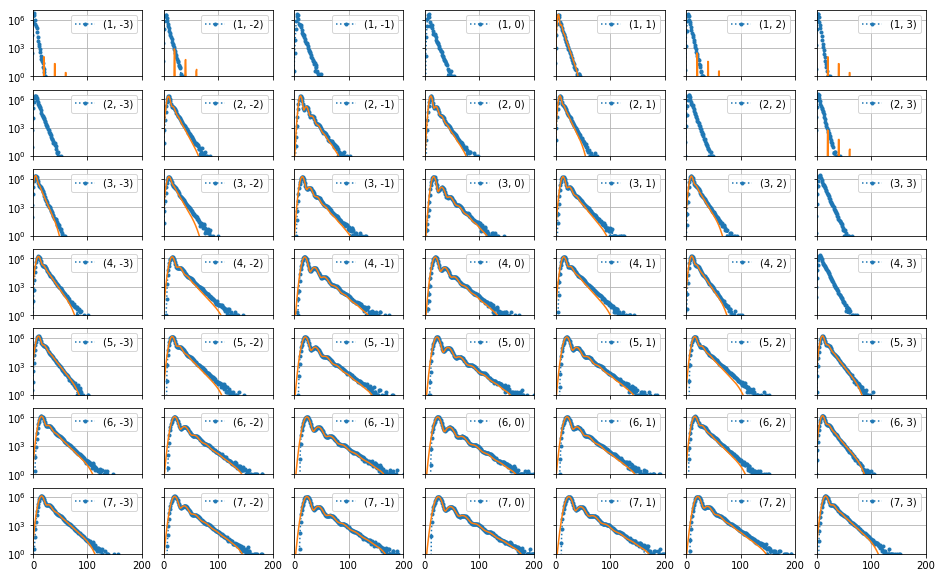

In [8]:
R = []
fig, ax = plt.subplots(
    7, 7, 
    figsize=(16, 10), 
    
    sharex=True, 
    sharey=True
)
for p in paths:
    info = parse_path(p)
    info_tuple = str((info['integral_width'], info['shift']))
    plt.sca(ax[
        info['integral_width']-1,
        info['shift']+3
    ])
    X, Y = read_charge_histo(p)
    plt.semilogy(X, Y, '.:', label=info_tuple)
    try:
        fit_results = fit_stuff(X, Y)
        fit_results.update(info)
        R.append(fit_results)
    except RuntimeError:
        print(info_tuple, 'Fit did not work')
    plt.xlim(0, 200)
    plt.ylim(1, 1e7)
    plt.grid()
    plt.legend(loc='upper right')
df = pd.DataFrame(R)

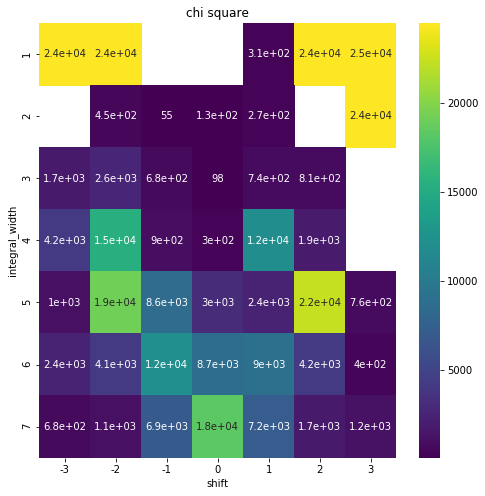

In [9]:
plt.figure(figsize=(8, 8))
sns.heatmap(
    df.pivot(
        index='integral_width',
        columns='shift',
        values='chi2_ndf'
    ), 
    annot=True,
    cmap='viridis',
    
)
plt.title('chi square')
None

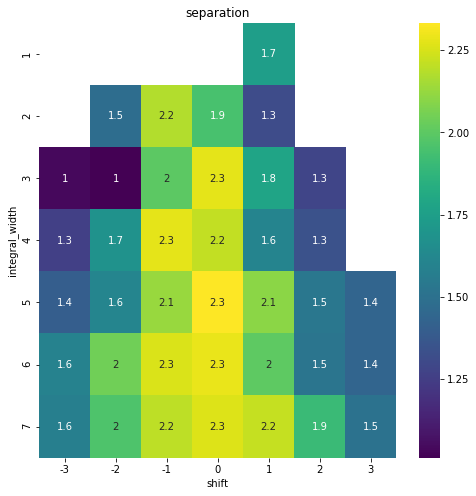

In [10]:
plt.figure(figsize=(8, 8))
sns.heatmap(
    df[df.chi2_ndf < 2.3e4].pivot(
        index='integral_width',
        columns='shift',
        values='separation'
    ), 
    annot=True,
    cmap='viridis'
)
plt.title('separation')

None